# Links

### [get reduced V fts](#reduced_V)

### [get reduced id fts](#reduced_id)

### [get reduced C fts](#reduced_C)

### [get reduced D fts](#reduced_D)

### [get reduced M fts](#reduced_M)

### [get reduced card+info fts](#reduced_card_info)

In [1]:
import pandas as pd
import numpy as np

# for plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
import plotly.figure_factory as ff

# for modeling
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from scipy.stats import chi2_contingency
from tqdm import tqdm
from collections import Counter

In [3]:
tqdm.pandas()

/Users/junseoklee/kaggle/IEEE-venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [575]:
tqdm._instances.clear()

# Import Data in the same ways as explained in the EDA notebook

In [4]:
#df_dtypes at the bottom

In [5]:
train_id = pd.read_csv('ieee-fraud-detection/train_identity.csv',dtype=df_dtypes) #df_dtypes at the bottom

In [6]:
train_trans = pd.read_csv('ieee-fraud-detection/train_transaction.csv',dtype=df_dtypes) 

In [7]:
test_id = pd.read_csv('ieee-fraud-detection/test_identity.csv',dtype=df_dtypes) #df_dtypes at the bottom

In [8]:
test_trans = pd.read_csv('ieee-fraud-detection/test_transaction.csv',dtype=df_dtypes)

In [10]:
TransIDs_with_id = train_id['TransactionID'].values

In [11]:
train_trans['trans_nulls']=train_trans.isna().sum(axis=1)

In [12]:
train_id['id_nulls']=train_id.isna().sum(axis=1)

In [9]:
df = train_trans.merge(train_id, how='left', on='TransactionID')

In [14]:
df['nulls'] = df['trans_nulls']+df['id_nulls'].fillna(40)

In [13]:
test_trans['trans_nulls']=test_trans.isna().sum(axis=1)

In [14]:
test_id['id_nulls']=test_id.isna().sum(axis=1)

In [10]:
df_test = test_trans.merge(test_id, how='left', on='TransactionID')

In [ ]:
df_test['nulls'] = df_test['trans_nulls']+df_test['id_nulls'].fillna(40)

In [15]:
del train_trans, train_id

In [ ]:
del test_trans, test_id

In [11]:
def feature_in_use(feature_to_look, features_to_use, verbose = False):
#    feature_to_look = 'email'
    feature_in_use_list = []
    for feature in features_to_use:
        if feature_to_look in feature:
                if verbose:
                    print(feature)
                feature_in_use_list.append(feature)
    return feature_in_use_list

In [12]:
id_cols = feature_in_use('id', df.columns) #categorical label
V_cols = feature_in_use('V', df.columns) # ordinal label
D_cols = [f'D{i}' for i in range(1,16)] # ordinal label
C_cols = [f'C{i}' for i in range(1,15)] #ordinal label
M_cols = feature_in_use('M', df.columns) #categorical label
card_cols = feature_in_use('card', df.columns) # card1, card2 numeric, card3 ,4, 5 categorical
info_cols = ['ProductCD','addr1','addr2','dist1','dist2',\
             'DeviceType', 'DeviceInfo','P_emaildomain','R_emaildomain'] # categorical label

In [667]:
Trans_cols = ['isFraud','TransactionID', 'TransactionDT', 'TransactionAmt']
# numeric_cols = list(lg_corr_ft)+['card2', 'id_02','C1']
object_cols = list(df.dtypes[df.dtypes == np.object].keys())
numeric_cols = list(set(df.columns)-set(object_cols)-set(Trans_cols))

In [662]:
def make_corr(df,ft_list,title='',with_TransDT=False):
    if with_TransDT:
        cols = ['TransactionDT'] + ft_list
    else:
        cols = ft_list
    plt.figure(figsize=(15,15))
    sns.heatmap(df[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if title!='': plt.title(title,fontsize=14)
    else: plt.title(ft_list[0]+' - '+ft_list[-1],fontsize=14)
    plt.show()

In [276]:
def nan_groups(df,col_list,thrsd = 0.99):
    cols = col_list.copy()
    n = len(cols)
    corr_df = df[cols].isna().corr()
    corr_grs = []
    for _ in range(n):
        try:
            i = 0
            gr = list(corr_df[cols[i]][corr_df[cols[i]] > thrsd].keys())
            corr_grs.append(gr)
            cols = [col for col in cols if col not in gr]
        except:
            break
    return corr_grs

In [787]:
# deal with an overlap
def corr_groups(df,col_list,thrsd = 0.75):
#     cols = col_list.copy()
#     n = len(cols)
    org_thrsd = thrsd
    def corr_groups_from_corr_df(corr_df,thrsd=thrsd):
        if thrsd >=1.0:
            thrsd = 1.0
        cols = list(corr_df.columns)
        n = len(corr_df)
        corr_grs = []
        for _ in range(n):
            try:
                i = 0
                gr = list(corr_df[cols[i]][corr_df[cols[i]] >= thrsd].keys())
                iter_gr = gr.copy()
                iter_gr.remove(cols[i])
                for col in iter_gr:
                    if max(corr_df[col].drop(col).keys(), key=lambda x:corr_df[col].drop(col)[x]) not in gr:
                        gr.remove(col)
                    elif (corr_df[col].loc[gr]<org_thrsd).sum()>0:
                        gr.remove(col)
                corr_grs.append(gr)
                cols = [col for col in cols if col not in gr]
            except:
                break
#         print(thrsd,len(corr_grs))
        flat_list = [item for sublist in corr_grs for item in sublist]
        if len(flat_list) > n:
            dup_fts = [ft for ft, count in Counter(flat_list).items() if count>1]

#             dup_grs={}
            dup_grs = []
            for ft in dup_fts:
                for gr in corr_grs:
                    if ft in gr:
                        dup_grs.append(gr)
            dup_grs = [grs for i, grs in enumerate(dup_grs) if grs not in list(dup_grs)[:i]] #remove duplicates
            for gr in dup_grs:
                corr_grs.remove(gr)
            flat_dup_grs_fts = [item for sublist in dup_grs for item in sublist]
            flat_dup_grs_fts = [item for i,item in enumerate(flat_dup_grs_fts) if item not in flat_dup_grs_fts[:i]]
            thrsd = thrsd+max((1-thrsd)/5,0.01)
            corr_grs_digged = corr_groups_from_corr_df(corr_df.loc[flat_dup_grs_fts,flat_dup_grs_fts],thrsd=thrsd)
            corr_grs = corr_grs+corr_grs_digged

        elif len(flat_list) == n:
            pass
        else:
            print('something wrong')
            print(f'{flat_list} with length {len(flat_list)} but n={n}')
        


        return corr_grs
    
    corr_df = abs(df[col_list].corr())
    corr_grs = corr_groups_from_corr_df(corr_df,thrsd=thrsd)
    
    single_gr_ft = [item for subitem in corr_grs if len(subitem)==1 for item in subitem]
    for ft in single_gr_ft:
        corr_grs.remove([ft])
    corr_grs = corr_grs+corr_groups_from_corr_df(corr_df.loc[single_gr_ft,single_gr_ft],thrsd=org_thrsd)
    assert len(col_list) == len([item for sublist in corr_grs for item in sublist]), 'length wrong'
    
    return corr_grs

In [788]:
def ft_corr_groups(df,ft_nan_gr):
    ft_corr_groups = {}
    for i in tqdm(range(len(ft_nan_gr))):
        ft_corr_groups[i]=corr_groups(df,ft_nan_gr[i])
    return ft_corr_groups

In [698]:
def get_ft_reduced(df,ft_corr_groups):
    ft_reduced = []
    for i in tqdm(range(len(ft_corr_groups))):
        for j in range(len(ft_corr_groups[i])):
            ft_reduced.append(max(df[ft_corr_groups[i][j]].nunique().keys(),\
                                  key = lambda x:df[ft_corr_groups[i][j]].nunique()[x]))
    ft_reduced = [col for col in df.columns if col in ft_reduced]
    return ft_reduced

In [746]:
def show_overlap(ft_nan_gr,ft_corr_groups):
    overlap = 0
    for i in range(len(ft_nan_gr)):
        n = 0
        for j in range(len(ft_corr_groups[i])):
            n+=len(ft_corr_groups[i][j])
        if n != len(ft_nan_gr[i]):
            print(f'there is an overlap for ft_nan_gr {i}')
            overlap +=1
    if overlap ==0:
        print(f'no overlap found')

In [213]:
cols_to_corr = V_cols
nan_corr_df = df[cols_to_corr].isna().corr()
high_nan_corr_sum = nan_corr_df.where((0.99>nan_corr_df)&(nan_corr_df>0.9)).sum()
high_nan_corr_sum[high_nan_corr_sum>0]

V12     20.065900
V13     20.065900
V14     20.065900
V15     20.065900
V16     20.065900
          ...    
V274    62.346464
V275    62.346464
V276    62.346464
V277    62.346464
V278    62.346464
Length: 157, dtype: float64

In [256]:
nan_corr_df['V272'][nan_corr_df['V272']>0.9]

V167    0.986116
V168    0.986116
V169    0.985144
V170    0.985144
V171    0.985144
          ...   
V274    0.946331
V275    0.946331
V276    0.946331
V277    0.946331
V278    0.946331
Name: V272, Length: 112, dtype: float64

In [253]:
high_nan_corr_sum[high_nan_corr_sum>92]

V220    92.818561
V221    92.818561
V222    92.818561
V227    92.818561
V234    92.818561
V238    92.818561
V239    92.818561
V245    92.818561
V250    92.818561
V251    92.818561
V255    92.818561
V256    92.818561
V259    92.818561
V270    92.818561
V271    92.818561
V272    92.818561
dtype: float64

In [251]:
high_nan_corr_sum[high_nan_corr_sum>0].unique()

array([20.06590043, 20.97798681, 59.23415871, 59.14609484, 62.34646374,
       92.81856099])

In [254]:
nan_corr_df['V272'][(nan_corr_df['V272']>0.9)&(nan_corr_df['V272']<0.99)]

V167    0.986116
V168    0.986116
V169    0.985144
V170    0.985144
V171    0.985144
          ...   
V274    0.946331
V275    0.946331
V276    0.946331
V277    0.946331
V278    0.946331
Name: V272, Length: 96, dtype: float64

In [259]:
playcol = ['V272','V278']

In [260]:
playdf = df[playcol]

In [123]:
playdf['V75'][playdf['V74'].isna()].notna()

6228

In [203]:
playdf[playcol[1]]

0         1.0
1         NaN
2         1.0
3         NaN
4         NaN
         ... 
590535    0.0
590536    1.0
590537    1.0
590538    2.0
590539    1.0
Name: V5, Length: 590540, dtype: float32

In [261]:
playlst = list(playdf[playcol[0]][playdf[playcol[0]].isna() != playdf[playcol[1]].isna()].keys())

In [262]:
playlst2 = playlst.copy()
if len(playlst)>0:
    for i in range(1,len(playlst)):
        if playlst[i-1]+1==playlst[i]:
            playlst2.remove(playlst[i])

In [263]:
len(playlst)

11510

In [264]:
len(playlst2)

10517

In [184]:
playlst2

[580737, 580775, 582307, 582312, 582334, 582367]

In [142]:
len(playlst2)

15637

In [135]:
(playdf['V75'].isna() != playdf['V74'].isna())[30:40]

30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38     True
39    False
dtype: bool

<a id='reduced_V'></a>

In [769]:
ft_nan_gr_dict = {}
ft_nan_gr_dict['V'] = V_nan_gr
ft_nan_gr_dict['id'] = id_nan_gr
ft_nan_gr_dict['C'] = C_nan_gr
ft_nan_gr_dict['D'] = D_nan_gr

In [770]:
ft_corr_gr_dict = {}
ft_corr_gr_dict['V'] = V_corr_groups
ft_corr_gr_dict['id'] = id_corr_groups
ft_corr_gr_dict['C'] = C_corr_groups
ft_corr_gr_dict['D'] = D_corr_groups

In [771]:
ft_reduced_dict = {}
ft_reduced_dict['V'] = V_reduced
ft_reduced_dict['id'] = id_reduced
ft_reduced_dict['C'] = C_reduced
ft_reduced_dict['D'] = D_reduced

# get reduced V fts  

In [265]:
cols_to_corr = V_cols
V_nan_gr = nan_groups(df,cols_to_corr,thrsd = 0.99)

In [266]:
len(V_nan_gr)

12

In [576]:
V_corr_groups = {}
for i in tqdm(range(len(V_nan_gr))):
    V_corr_groups[i]=corr_groups(df,V_nan_gr[i])
#     for j in range(len(V_corr_groups[i])):
#         n+=len(V_corr_groups[i][j])
#     if n != len(V_nan_gr[i]):
#         V_corr_groups[i]=corr_groups(df,V_nan_gr[i],thrsd=0.7)

100%|██████████| 12/12 [00:53<00:00,  4.43s/it]


In [577]:
for i in range(len(V_nan_gr)):
    n = 0
    for j in range(len(V_corr_groups[i])):
        n+=len(V_corr_groups[i][j])
    if n != len(V_nan_gr[i]):
        print(f'there is an overlap for V_nan_gr {i}')

In [595]:
V_reduced = []
for i in tqdm(range(len(V_corr_groups))):
    for j in range(len(V_corr_groups[i])):
        V_reduced.append(max(df[V_corr_groups[i][j]].nunique().keys(), key = lambda x:df[V_corr_groups[i][j]].nunique()[x]))

100%|██████████| 12/12 [00:12<00:00,  1.03s/it]


In [703]:
V_reduced = get_ft_reduced(df,V_corr_groups)

100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


In [704]:
V_reduced

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V55',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91',
 'V98',
 'V99',
 'V104',
 'V105',
 'V107',
 'V108',
 'V109',
 'V111',
 'V114',
 'V115',
 'V117',
 'V118',
 'V120',
 'V121',
 'V123',
 'V124',
 'V126',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V155',
 'V160',
 'V162',
 'V165',
 'V169',
 'V171',
 'V173',
 'V174',
 'V175',
 'V176',
 'V180',
 'V181',
 'V185',
 'V187',
 'V188',
 'V197',
 'V198',
 'V202',
 'V203',
 'V204',
 'V205',
 'V207',
 'V209',
 'V210',
 'V216',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V234',
 'V238',
 'V240',
 'V244',
 'V248',
 'V250',
 'V252',
 'V253',
 'V257',
 'V258',
 'V260',
 'V261',
 'V264',
 'V265',
 'V266',
 'V267',
 'V271',
 'V277',
 'V281',
 'V283',
 'V284',
 

<a id='reduced_id'></a>

# get reduced id fts 

In [668]:
id_object_cols = [col for col in id_cols if col in object_cols]
id_numeric_cols = [col for col in id_cols if col in numeric_cols]

In [678]:
id_booln_cols = ['id_12','id_15','id_16','id_27','id_28','id_29','id_35','id_36','id_37','id_38']
id_cats_cols = ['id_23','id_30','id_31','id_33','id_34']
mp = {'Unknown':0,'NotFound':1,'Found':2,'New':3,'F':0,'T':1}
for c in id_booln_cols: df[c] = df[c].map(mp)

In [680]:
len(id_booln_cols)+len(id_cats_cols)+len(id_numeric_cols)

38

In [681]:
cols_to_corr = id_numeric_cols+id_booln_cols
id_nan_gr = nan_groups(df,cols_to_corr,thrsd = 0.99)

In [682]:
id_nan_gr

[['id_01', 'id_12'],
 ['id_02',
  'id_11',
  'id_17',
  'id_19',
  'id_20',
  'id_15',
  'id_28',
  'id_29',
  'id_35',
  'id_36',
  'id_37',
  'id_38'],
 ['id_03', 'id_04'],
 ['id_05', 'id_06'],
 ['id_07', 'id_08', 'id_21', 'id_22', 'id_25', 'id_26', 'id_27'],
 ['id_09', 'id_10'],
 ['id_13'],
 ['id_14'],
 ['id_18'],
 ['id_24'],
 ['id_32'],
 ['id_16']]

In [688]:
id_corr_groups = ft_corr_groups(df,id_nan_gr)

100%|██████████| 12/12 [00:00<00:00, 23.28it/s]


In [689]:
id_corr_groups

{0: [['id_01'], ['id_12']],
 1: [['id_17', 'id_35'],
  ['id_28', 'id_29'],
  ['id_02'],
  ['id_11'],
  ['id_19'],
  ['id_20'],
  ['id_15'],
  ['id_36'],
  ['id_37'],
  ['id_38']],
 2: [['id_03'], ['id_04']],
 3: [['id_05'], ['id_06']],
 4: [['id_07'],
  ['id_08'],
  ['id_21'],
  ['id_22'],
  ['id_25'],
  ['id_26'],
  ['id_27']],
 5: [['id_09'], ['id_10']],
 6: [['id_13']],
 7: [['id_14']],
 8: [['id_18']],
 9: [['id_24']],
 10: [['id_32']],
 11: [['id_16']]}

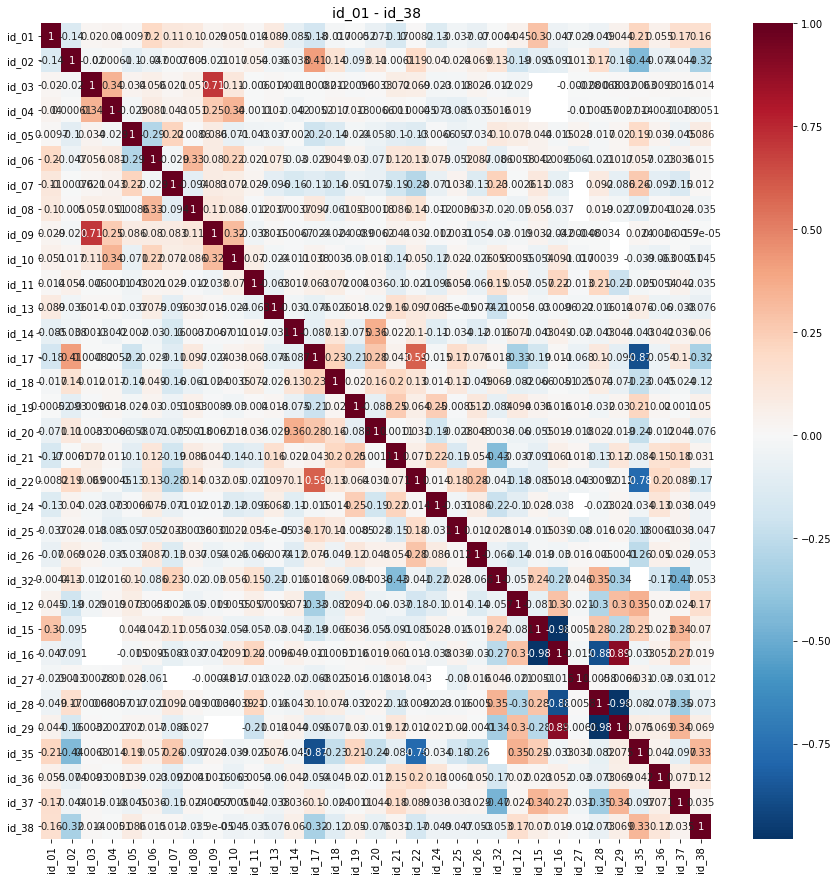

In [685]:
make_corr(df,id_numeric_cols+id_booln_cols)

In [691]:
for i in range(len(id_nan_gr)):
    n = 0
    for j in range(len(id_corr_groups[i])):
        n+=len(id_corr_groups[i][j])
    if n != len(id_nan_gr[i]):
        print(f'there is an overlap for V_nan_gr {i}')

In [700]:
id_reduced = get_ft_reduced(df,id_corr_groups)

100%|██████████| 12/12 [00:00<00:00, 20.96it/s]


In [701]:
id_reduced

['id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_32',
 'id_36',
 'id_37',
 'id_38']

<a id='reduced_C'></a>

# get reduced C fts

In [708]:
cols_to_corr = C_cols
C_nan_gr = nan_groups(df,cols_to_corr,thrsd = 0.99)

In [709]:
C_nan_gr

[[], [], [], [], [], [], [], [], [], [], [], [], [], []]

- ### no missing data for C

In [715]:
C_nan_gr = [C_cols]

In [728]:
C_corr_groups = ft_corr_groups(df,C_nan_gr)

100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


In [729]:
C_corr_groups

{0: [['C5', 'C9'],
  ['C1', 'C2', 'C6', 'C11', 'C14', 'C4', 'C7', 'C8', 'C10', 'C12'],
  ['C3'],
  ['C13']]}

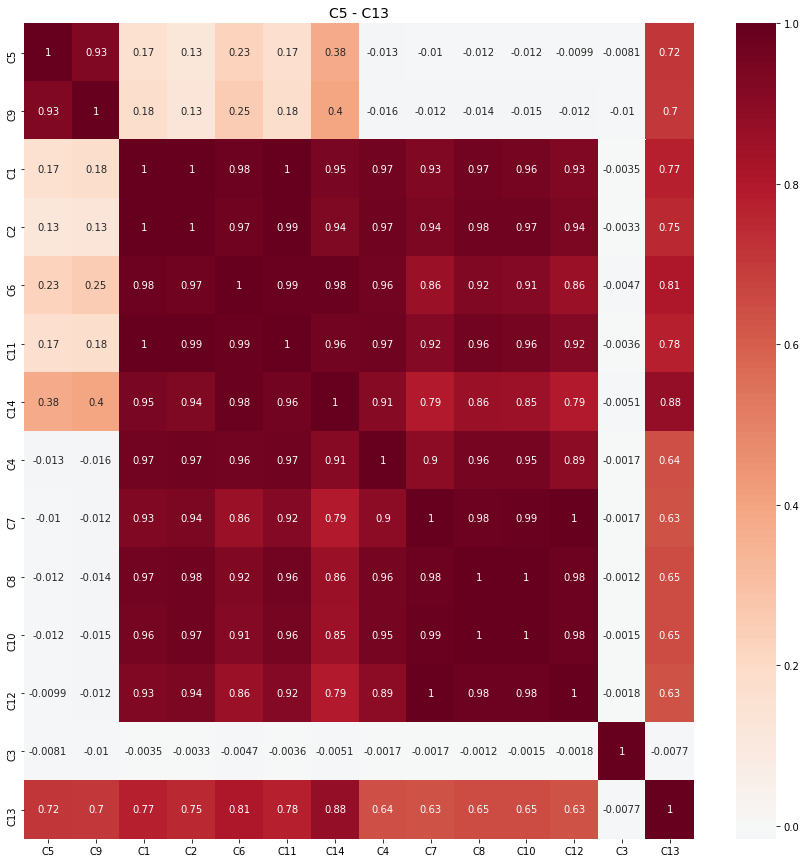

In [730]:
make_corr(df,['C5', 'C9']+
  ['C1', 'C2', 'C6', 'C11', 'C14', 'C4', 'C7', 'C8', 'C10', 'C12']+
  ['C3']+
  ['C13'])

In [731]:
C_corr_groups

{0: [['C5', 'C9'],
  ['C1', 'C2', 'C6', 'C11', 'C14', 'C4', 'C7', 'C8', 'C10', 'C12'],
  ['C3'],
  ['C13']]}

In [743]:
'%s' %"C_nan_gr"

'C_nan_gr'

In [741]:
vars()["C"+'_nan_gr']

[['C1',
  'C2',
  'C3',
  'C4',
  'C5',
  'C6',
  'C7',
  'C8',
  'C9',
  'C10',
  'C11',
  'C12',
  'C13',
  'C14']]

In [747]:
show_overlap(C_nan_gr,C_corr_groups)

no overlap found


In [748]:
C_reduced = get_ft_reduced(df,C_corr_groups)

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


In [749]:
C_reduced

['C1', 'C3', 'C5', 'C13']

<a id='reduced_D'></a>

# get reduced D fts

In [750]:
cols_to_corr = D_cols
D_nan_gr = nan_groups(df,cols_to_corr,thrsd = 0.99)

In [752]:
D_nan_gr

[['D1'],
 ['D2'],
 ['D3'],
 ['D4'],
 ['D5'],
 ['D6'],
 ['D7'],
 ['D8', 'D9'],
 ['D10'],
 ['D11'],
 ['D12'],
 ['D13'],
 ['D14'],
 ['D15']]

In [753]:
D_corr_groups = ft_corr_groups(df,D_nan_gr)

100%|██████████| 14/14 [00:00<00:00, 107.52it/s]


In [754]:
D_corr_groups

{0: [['D1']],
 1: [['D2']],
 2: [['D3']],
 3: [['D4']],
 4: [['D5']],
 5: [['D6']],
 6: [['D7']],
 7: [['D8'], ['D9']],
 8: [['D10']],
 9: [['D11']],
 10: [['D12']],
 11: [['D13']],
 12: [['D14']],
 13: [['D15']]}

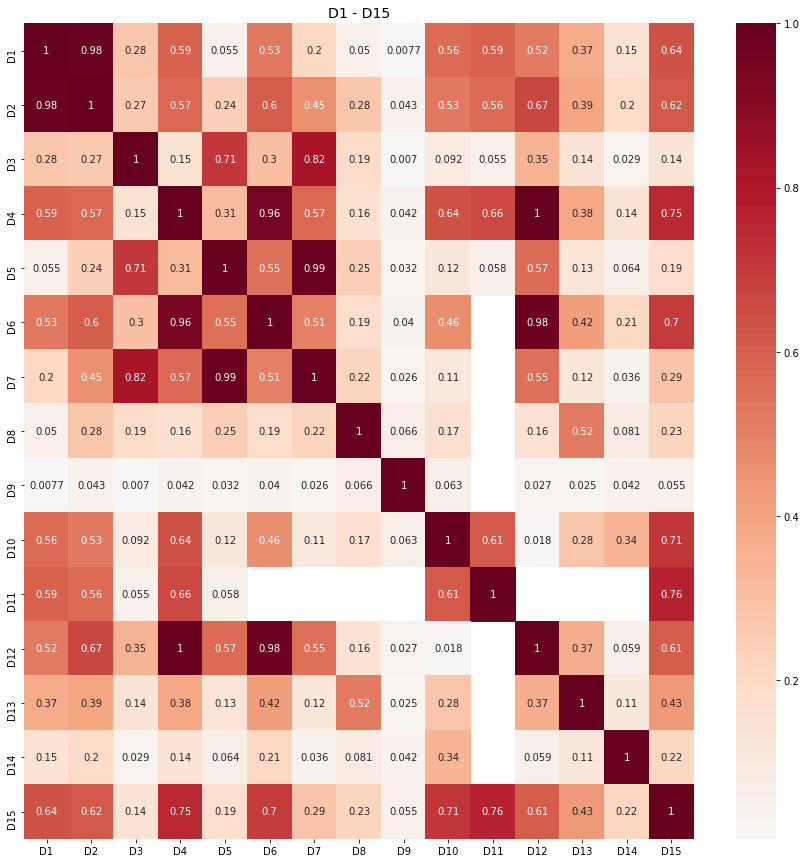

In [755]:
make_corr(df,D_cols)

In [758]:
D_corr_groups

{0: [['D1']],
 1: [['D2']],
 2: [['D3']],
 3: [['D4']],
 4: [['D5']],
 5: [['D6']],
 6: [['D7']],
 7: [['D8'], ['D9']],
 8: [['D10']],
 9: [['D11']],
 10: [['D12']],
 11: [['D13']],
 12: [['D14']],
 13: [['D15']]}

In [759]:
show_overlap(D_nan_gr,D_corr_groups)

no overlap found


In [760]:
D_reduced = get_ft_reduced(df,D_corr_groups)

100%|██████████| 14/14 [00:00<00:00, 43.64it/s]


In [761]:
D_reduced

['D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15']

- ### all D cols

<a id='reduced_M'></a>

# get reduced M fts

In [781]:
M_mp = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
for c in M_cols: df[c] = df[c].map(M_mp)

In [782]:
ft = 'M'
cols_to_corr = M_cols
ft_nan_gr_dict[ft] = nan_groups(df,cols_to_corr,thrsd = 0.99)

In [789]:
ft_nan_gr_dict[ft]

[['M1', 'M2', 'M3'], ['M4'], ['M5'], ['M6'], ['M7', 'M8', 'M9']]

In [790]:
ft_corr_gr_dict[ft] = ft_corr_groups(df,ft_nan_gr_dict[ft])

100%|██████████| 5/5 [00:00<00:00, 38.25it/s]


In [791]:
ft_corr_gr_dict[ft]

{0: [['M1'], ['M2'], ['M3']],
 1: [['M4']],
 2: [['M5']],
 3: [['M6']],
 4: [['M7'], ['M8'], ['M9']]}

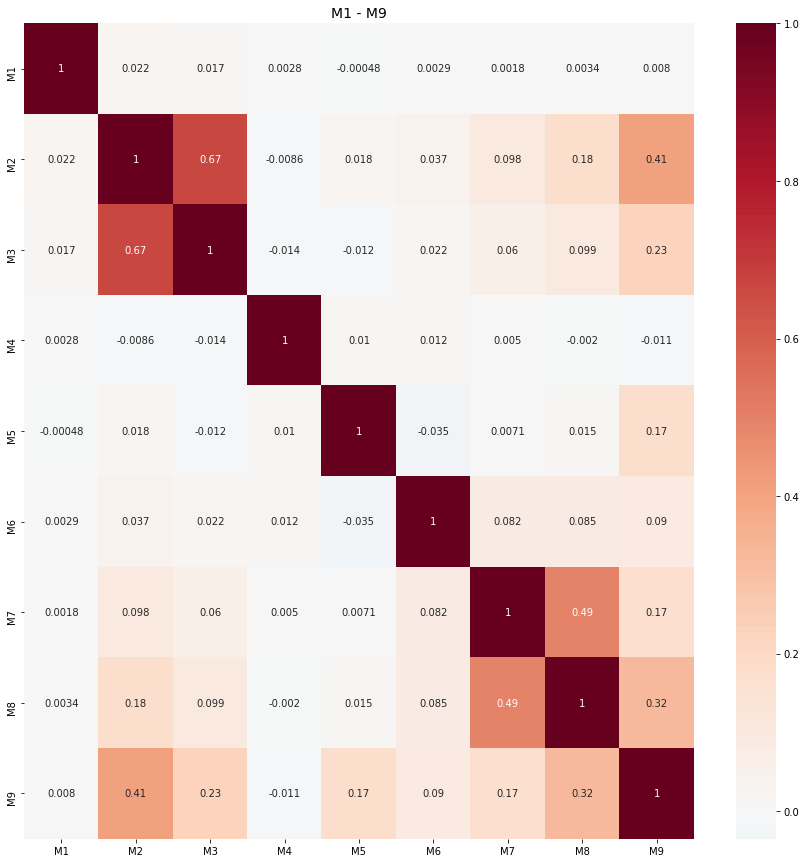

In [793]:
make_corr(df,M_cols)

In [794]:
show_overlap(ft_nan_gr_dict[ft],ft_corr_gr_dict[ft])

no overlap found


In [795]:
ft_reduced_dict[ft] = get_ft_reduced(df,ft_corr_gr_dict[ft])

100%|██████████| 5/5 [00:00<00:00, 33.30it/s]


In [796]:
ft_reduced_dict[ft]

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

- ### all M cols

<a id='reduced_card_info'></a>

# get reduced card+info fts

In [802]:
ft = 'info'
cols_to_corr = card_cols+info_cols
cols_to_corr = [col for col in cols_to_corr if col not in object_cols]
cols_to_corr.remove('card1')
ft_nan_gr_dict[ft] = nan_groups(df,cols_to_corr,thrsd = 0.99)
ft_nan_gr_dict[ft].append(['card1'])

In [803]:
ft_nan_gr_dict[ft]

[['card2'],
 ['card3'],
 ['card5'],
 ['addr1', 'addr2'],
 ['dist1'],
 ['dist2'],
 ['card1']]

In [804]:
ft_corr_gr_dict[ft] = ft_corr_groups(df,ft_nan_gr_dict[ft])

100%|██████████| 7/7 [00:00<00:00, 119.97it/s]


In [805]:
ft_corr_gr_dict[ft]

{0: [['card2']],
 1: [['card3']],
 2: [['card5']],
 3: [['addr1'], ['addr2']],
 4: [['dist1']],
 5: [['dist2']],
 6: [['card1']]}

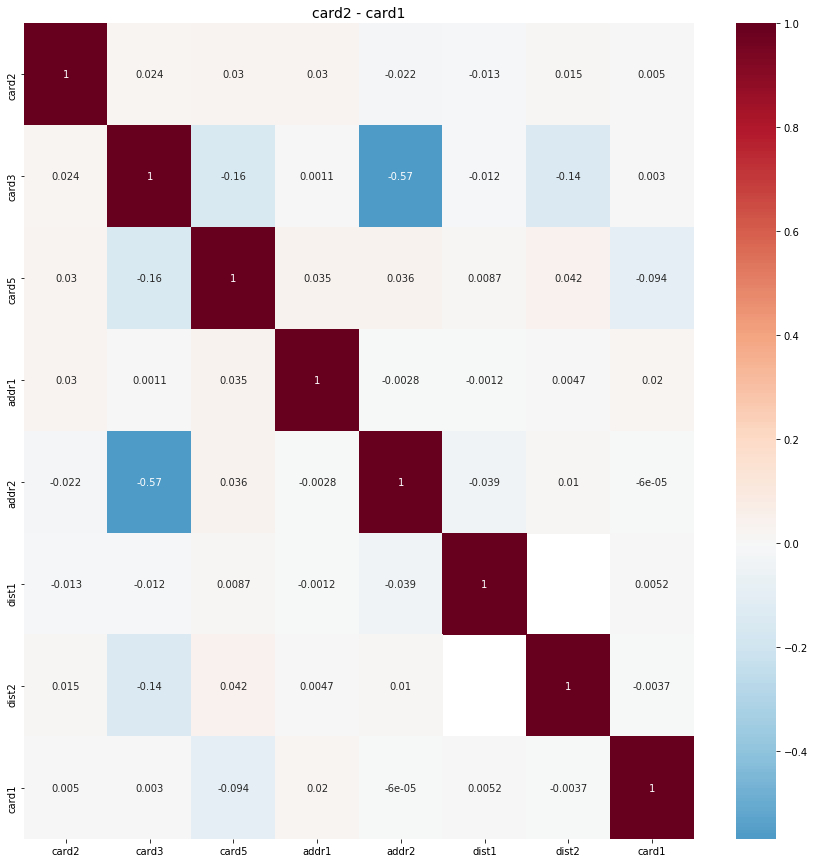

In [807]:
make_corr(df,cols_to_corr+['card1'])

In [814]:
df['dist2'][df['dist1'].notna()].notna().sum()

0

In [815]:
show_overlap(ft_nan_gr_dict[ft],ft_corr_gr_dict[ft])

no overlap found


In [816]:
ft_reduced_dict[ft] = get_ft_reduced(df,ft_corr_gr_dict[ft])

100%|██████████| 7/7 [00:00<00:00, 43.32it/s]


In [817]:
ft_reduced_dict[ft]

['card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2']

- ### all card_info cols

# (Data Exploring in 'Kaggle_IEEE_Fraud_Detection_EDA')

In [597]:
# Function to plot the statistics for categorical data
def bar_plot(df, feature, target = 'isFraud', fill_na = 'null', others_threshold = 5000, 
             target_plots =True, xtick_rotate = False, reduced = False, sorted_plot_order = False):
#     if sorted_plot_order:
#         assert (type(fill_na) == np.int)|(type(fill_na) == np.float), 'fill_na should be number for sorted_plot_order'
    total_num = len(df)
    if feature != target:
        df_trans = df[[target, feature, 'TransactionAmt']].copy()
        if fill_na is not None:
            df_trans[feature] = df_trans[feature].fillna(fill_na)

            
        df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
                    [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
                     , feature] = "others"
        
#         if df_trans[feature].dtypes.kind in 'OS':
#             df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
#                     [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
#                      , feature] = "others"
#         elif df_trans[feature].dtypes.kind in 'buicf':
#             df_trans.loc[df_trans[feature].isin(df_trans[feature].value_counts(dropna=False)\
#                     [df_trans[feature].value_counts(dropna=False) <= others_threshold ].index)\
#                      , feature] = -888

        tmp = pd.crosstab(df_trans[feature], df_trans[target], normalize='index') * 100
        tmp.reset_index(inplace = True)
        tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    #    plot_order = list(df_trans[feature].unique())
#         if sorted_plot_order:
#             plot_order = np.sort(df_trans[feature].unique())
#         else:
#             plot_order = df_trans[feature].value_counts().keys()

    #     perc_amt = (df_trans.groupby([target,feature])['TransactionAmt'].sum() / total_amt * 100).unstack(target)
    #     perc_amt = perc_amt.reset_index()
    #     perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
        groupby_amt = df_trans.groupby([feature, target])['TransactionAmt'].sum()

        tmp_amt = (groupby_amt).unstack(target) 
        tmp_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
        perc_amt = tmp_amt.div(tmp_amt.sum(axis=1), axis=0) *100
        perc_amt.reset_index(inplace = True)
        tmp_amt.reset_index(inplace = True)
        tmp_amt['total'] = tmp_amt['NoFraud']+tmp_amt['Fraud']
        total_amt = tmp_amt['total'].sum()

        tmp_amt_expanded = pd.DataFrame(groupby_amt).reset_index()
        
    
    elif feature == target:
        target_plots = False
        df_trans = df[[feature, 'TransactionAmt']].copy()
        groupby_amt = df_trans.groupby([feature])['TransactionAmt'].sum()
        tmp_amt = pd.DataFrame(groupby_amt).reset_index()
        tmp_amt.rename(columns={'TransactionAmt':'total'}, inplace = True)
        total_amt = tmp_amt['total'].sum()
    

    if sorted_plot_order:
        str_val = []
        num_val = []
        for value in df_trans[feature].unique():
            if type(value) == np.str:
                str_val.append(value)
            else:
                num_val.append(value)
        plot_order = list(np.sort(str_val))+list(np.sort(num_val))
    else:
        plot_order = df_trans[feature].value_counts().keys()
      
                
    plt.figure(figsize=(14,13))
    if target_plots & (not reduced):
        title_y = 0.92
    elif reduced:
#        title_y = 1.02 #if use tight layout
        title_y = 0.94
    else:
        title_y = 0.95 #default 0.98
    plt.suptitle(f'{feature} Distributions', fontsize=22, y=title_y)
        
    plt.subplot(321)
    g = sns.countplot(x=feature, data=df_trans, order = plot_order)
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

    g.set_title(f"Frequency", fontsize=19)
    g.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha="right")
    g.set_ylabel("Count", fontsize=17)
#     if feature == target:
#         g.set_ylim(0,total_num *1.1)
#     else:
#         g.set_ylim(0,550000 )
    heights = []
    for p in g.patches:
        height = p.get_height()
        heights.append(height)
#         if i == 0:
#             max_height = height   #bars are in descending order
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_num*100),
                ha="center", fontsize=14)
    g.set_ylim(0, max(heights) *1.1 )
    
    if reduced:
        g_pt = g.twinx()
        g_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g_pt.set_ylabel("% of Fraud (Counts)", fontsize=16)

    if (target_plots) & (not reduced):
        plt.subplot(322)
        g2 = sns.countplot(x=feature, hue=target, data=df_trans, order = plot_order)

        g2_pt = g2.twinx()
        g2_pt = sns.pointplot(x=feature, y='Fraud', data=tmp, color='black', order=plot_order, legend=False)
        g2_pt.set_ylabel("% of Fraud (Counts)", fontsize=16)

        g2.set_title(f"Frequency by Target({target})", fontsize=19)
        g2.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g2.set_xticklabels(g2.get_xticklabels(), rotation=30, ha="right")
        g2.set_ylabel("Count", fontsize=17)

    if (target_plots) & (not reduced):
        plt.subplot(323)
    elif (not target_plots) | reduced:
        plt.subplot(322)
    sns.set_color_codes("pastel")
    g4 = sns.barplot(x=feature, y='total', data=tmp_amt , order = plot_order )
    g4.set_title(f"Transaction Amount", fontsize=20)
    g4.set_xlabel(f"{feature} Values", fontsize=17)
    if xtick_rotate:
        g4.set_xticklabels(g4.get_xticklabels(), rotation=30, ha="right")
    g4.set_ylabel("Transaction Amt $", fontsize=17)
    
    heights = []
    for p in g4.patches:
        height = p.get_height()
        heights.append(height)
        g4.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt*100),
            ha="center", fontsize=14)
    g4.set_ylim(0, max(heights) * 1.1 )
    
    if reduced:
        g4_pt = g4.twinx()
        g4_pt = sns.pointplot(x=feature, y='Fraud', data=perc_amt, order=plot_order,
                           color='black', legend=False )
        g4_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)
    
    
    if target_plots & (not reduced):
        plt.subplot(324)
        sns.set_color_codes("muted")
        g4_hue = sns.barplot(x=feature, y='TransactionAmt', data=tmp_amt_expanded , hue = target , order = plot_order)
        g4_hue.set_title(f"Transaction Amount by Target", fontsize=20)
        g4_hue.set_xlabel(f"{feature} Values", fontsize=17)
        if xtick_rotate:
            g4_hue.set_xticklabels(g4_hue.get_xticklabels(), rotation=30, ha="right")
        g4_hue.set_ylabel("Transaction Amt $", fontsize=17)    
        
        g4_pt = g4_hue.twinx()
        g4_pt = sns.pointplot(x=feature, y='Fraud', data=perc_amt, order=plot_order,
                           color='black', legend=False )
        g4_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)


        plt.subplot(313)
        g3 = sns.boxenplot(x=feature, y='TransactionAmt', hue=target, 
                      data=df_trans[df_trans['TransactionAmt'] <= 2000] , order = plot_order )
        g3.set_title(f"Transaction Amount Distribution", fontsize=20)
        g3.set_xlabel(f"{feature} Values", fontsize=17)
#         if xtick_rotate:
#             g3.set_xticklabels(g3.get_xticklabels(), rotation=30,ha="right")
        g3.set_ylabel("Transaction Amt $", fontsize=17)


#        plt.tight_layout()
    if reduced:
        plt.subplots_adjust(wspace = 0.25)
    else:
        plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()


# Function to plot Histograms for float valued features
def dist_plot(df, feature, target = 'isFraud', fill_nan = False ,bin_num = 30 , df_test=pd.DataFrame(),\
              TransAmt_plot = True):
    plt.figure(figsize=(14,8))
    plt.suptitle(f'{feature} Distributions', fontsize=22)
    TransAmt = (feature == 'TransactionAmt')
    if len(df_test) == 0:
        if TransAmt:
            df_trans = df[[target, 'TransactionAmt']].copy()
        else:
            df_trans = df[[target, feature, 'TransactionAmt']].copy()
        if fill_nan:
            df_trans[feature].fillna(df_trans[feature].mean(), inplace = True)
            df_NoFraud = df_trans[df_trans[target] == 0]
            df_Fraud = df_trans[df_trans[target] == 1]
        else:
            df_NoFraud = df_trans[(df_trans[target] == 0) & (df_trans[feature].notna())]
            df_Fraud = df_trans[(df_trans[target] == 1) & (df_trans[feature].notna())]

        plt.subplot(211)


        bin_num = bin_num

        g = sns.distplot(df_NoFraud[feature], bins=bin_num, kde=False, label='NoFraud')
        height = []
        x_values = []
        bin_edges = []
        for i, p in enumerate(g.patches):
            if i == 0:
                bin_edges.append(p.get_x())
            height.append(p.get_height()) 
            x_values.append(p.get_x()+p.get_width()/2.)
            bin_edges.append(p.get_x()+p.get_width())
        g = sns.distplot(df_Fraud[feature], bins=bin_num, kde=False, label='Fraud')

        height_f = []
        for p in g.patches[bin_num:]:
            height_f.append(p.get_height())
        fraud_perc = np.array(height_f)/(np.array(height_f)+np.array(height)) *100


        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency by Target", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)

        df_f_perc =  pd.DataFrame({feature:x_values ,'Fraud': fraud_perc})

        g_pt = g.twinx()
        g_pt = sns.distplot(df_f_perc[feature], hist=True, kde = False, rug=False, bins = bin_edges,\
                hist_kws={'weights': df_f_perc['Fraud'],"histtype": "step","linewidth": 3 ,\
                          'color':'k'}, label='% of Fraud each bin')
        g_pt.set_ylabel("% of Fraud (counts)", fontsize=16)
        g_pt.legend()

        if (TransAmt ==False)&(TransAmt_plot):
            plt.subplot(212)

            g2 = sns.distplot(df_NoFraud[feature], bins=bin_num, kde=False,\
                              label='NoFraud',hist_kws={'weights': df_NoFraud['TransactionAmt']})
            height = []
            for i, p in enumerate(g2.patches):
                height.append(p.get_height())

            g2 = sns.distplot(df_Fraud[feature], bins=bin_num, kde=False,\
                              label='Fraud',hist_kws={'weights': df_Fraud['TransactionAmt']})
            height_f = []
            for p in g2.patches[bin_num:]:
                height_f.append(p.get_height())
            fraud_perc = np.array(height_f)/(np.array(height_f)+np.array(height)) *100

            g2.legend(loc='upper left')
            g2.set_title(f"{feature} Transaction Amount by Target", fontsize=20)
            g2.set_xlabel(f"{feature} Values", fontsize=18)
            g2.set_ylabel("TransAmt $ by bin", fontsize=18)

            df_f_perc =  pd.DataFrame({feature:x_values ,'Fraud': fraud_perc})

            g2_pt = g2.twinx()
            g2_pt = sns.distplot(df_f_perc[feature], hist=True, kde = False, rug=False, bins = bin_edges,\
                    hist_kws={'weights': df_f_perc['Fraud'],"histtype": "step","linewidth": 3 ,\
                              'color':'k'},  label='% of Fraud each bin')
            g2_pt.set_ylabel("% of Fraud ($ Amount)", fontsize=16)
            g2_pt.legend()

        plt.subplots_adjust(hspace = 0.6, top = 0.85)
        plt.show()

        
    elif len(df_test)>0:
        if TransAmt:
            df_trans = df[['TransactionAmt']].copy()
            df_test = df_test[['TransactionAmt']].copy()
        else:
            df_trans = df[[ feature, 'TransactionAmt']].copy()
            df_test = df_test[[ feature, 'TransactionAmt']].copy()
        if fill_nan:
            df_trans[[feature]].fillna(df_trans.mean(), inplace = True)
            df_test[[feature]].fillna(df_trans.mean(), inplace = True)
            
        plt.subplot(211)

        bin_num = 30

        g = sns.distplot(df_trans[feature], bins=bin_num, kde=False, label='train')
        bin_width = next(iter(g.patches)).get_width()
        bin_arr = np.arange(df_test[feature].min(), df_test[feature].max(), bin_width)
        g = sns.distplot(df_test[feature], bins=bin_arr, kde=False, label='test')
      
        
        g.legend(loc='upper left')
        g.set_title(f"{feature} Frequency", fontsize=20)
        g.set_xlabel(f"{feature} Values", fontsize=18)
        g.set_ylabel("Counts by bin", fontsize=18)


        if not TransAmt:
            plt.subplot(212)

            g2 = sns.distplot(df_trans[feature], bins=bin_num, kde=False,\
                              label='train',hist_kws={'weights': df_trans['TransactionAmt']})
            g2 = sns.distplot(df_test[feature], bins=bin_arr, kde=False,\
                              label='test',hist_kws={'weights': df_test['TransactionAmt']})

            g2.legend(loc='upper left')
            g2.set_title(f"{feature} Transaction Amount", fontsize=20)
            g2.set_xlabel(f"{feature} Values", fontsize=18)
            g2.set_ylabel("TransAmt $ by bin", fontsize=18)

        plt.subplots_adjust(hspace = 0.6, top = 0.85)
#         plt.tight_layout()
        plt.show()

In [2]:
df_dtypes = {'TransactionID': np.int32,
 'isFraud': np.int8,
 'TransactionDT': np.int32,
 'TransactionAmt': np.float32,
 'ProductCD': np.object_,
 'card1': np.int32,
 'card2': np.float32,
 'card3': np.float32,
 'card4': np.object_,
 'card5': np.float32,
 'card6': np.object_,
 'addr1': np.float32,
 'addr2': np.float32,
 'dist1': np.float32,
 'dist2': np.float32,
 'P_emaildomain': np.object_,
 'R_emaildomain': np.object_,
 'C1': np.float32,
 'C2': np.float32,
 'C3': np.float32,
 'C4': np.float32,
 'C5': np.float32,
 'C6': np.float32,
 'C7': np.float32,
 'C8': np.float32,
 'C9': np.float32,
 'C10': np.float32,
 'C11': np.float32,
 'C12': np.float32,
 'C13': np.float32,
 'C14': np.float32,
 'D1': np.float32,
 'D2': np.float32,
 'D3': np.float32,
 'D4': np.float32,
 'D5': np.float32,
 'D6': np.float32,
 'D7': np.float32,
 'D8': np.float32,
 'D9': np.float32,
 'D10': np.float32,
 'D11': np.float32,
 'D12': np.float32,
 'D13': np.float32,
 'D14': np.float32,
 'D15': np.float32,
 'M1': np.object_,
 'M2': np.object_,
 'M3': np.object_,
 'M4': np.object_,
 'M5': np.object_,
 'M6': np.object_,
 'M7': np.object_,
 'M8': np.object_,
 'M9': np.object_,
 'V1': np.float32,
 'V2': np.float32,
 'V3': np.float32,
 'V4': np.float32,
 'V5': np.float32,
 'V6': np.float32,
 'V7': np.float32,
 'V8': np.float32,
 'V9': np.float32,
 'V10': np.float32,
 'V11': np.float32,
 'V12': np.float32,
 'V13': np.float32,
 'V14': np.float32,
 'V15': np.float32,
 'V16': np.float32,
 'V17': np.float32,
 'V18': np.float32,
 'V19': np.float32,
 'V20': np.float32,
 'V21': np.float32,
 'V22': np.float32,
 'V23': np.float32,
 'V24': np.float32,
 'V25': np.float32,
 'V26': np.float32,
 'V27': np.float32,
 'V28': np.float32,
 'V29': np.float32,
 'V30': np.float32,
 'V31': np.float32,
 'V32': np.float32,
 'V33': np.float32,
 'V34': np.float32,
 'V35': np.float32,
 'V36': np.float32,
 'V37': np.float32,
 'V38': np.float32,
 'V39': np.float32,
 'V40': np.float32,
 'V41': np.float32,
 'V42': np.float32,
 'V43': np.float32,
 'V44': np.float32,
 'V45': np.float32,
 'V46': np.float32,
 'V47': np.float32,
 'V48': np.float32,
 'V49': np.float32,
 'V50': np.float32,
 'V51': np.float32,
 'V52': np.float32,
 'V53': np.float32,
 'V54': np.float32,
 'V55': np.float32,
 'V56': np.float32,
 'V57': np.float32,
 'V58': np.float32,
 'V59': np.float32,
 'V60': np.float32,
 'V61': np.float32,
 'V62': np.float32,
 'V63': np.float32,
 'V64': np.float32,
 'V65': np.float32,
 'V66': np.float32,
 'V67': np.float32,
 'V68': np.float32,
 'V69': np.float32,
 'V70': np.float32,
 'V71': np.float32,
 'V72': np.float32,
 'V73': np.float32,
 'V74': np.float32,
 'V75': np.float32,
 'V76': np.float32,
 'V77': np.float32,
 'V78': np.float32,
 'V79': np.float32,
 'V80': np.float32,
 'V81': np.float32,
 'V82': np.float32,
 'V83': np.float32,
 'V84': np.float32,
 'V85': np.float32,
 'V86': np.float32,
 'V87': np.float32,
 'V88': np.float32,
 'V89': np.float32,
 'V90': np.float32,
 'V91': np.float32,
 'V92': np.float32,
 'V93': np.float32,
 'V94': np.float32,
 'V95': np.float32,
 'V96': np.float32,
 'V97': np.float32,
 'V98': np.float32,
 'V99': np.float32,
 'V100': np.float32,
 'V101': np.float32,
 'V102': np.float32,
 'V103': np.float32,
 'V104': np.float32,
 'V105': np.float32,
 'V106': np.float32,
 'V107': np.float32,
 'V108': np.float32,
 'V109': np.float32,
 'V110': np.float32,
 'V111': np.float32,
 'V112': np.float32,
 'V113': np.float32,
 'V114': np.float32,
 'V115': np.float32,
 'V116': np.float32,
 'V117': np.float32,
 'V118': np.float32,
 'V119': np.float32,
 'V120': np.float32,
 'V121': np.float32,
 'V122': np.float32,
 'V123': np.float32,
 'V124': np.float32,
 'V125': np.float32,
 'V126': np.float32,
 'V127': np.float32,
 'V128': np.float32,
 'V129': np.float32,
 'V130': np.float32,
 'V131': np.float32,
 'V132': np.float32,
 'V133': np.float32,
 'V134': np.float32,
 'V135': np.float32,
 'V136': np.float32,
 'V137': np.float32,
 'V138': np.float32,
 'V139': np.float32,
 'V140': np.float32,
 'V141': np.float32,
 'V142': np.float32,
 'V143': np.float32,
 'V144': np.float32,
 'V145': np.float32,
 'V146': np.float32,
 'V147': np.float32,
 'V148': np.float32,
 'V149': np.float32,
 'V150': np.float32,
 'V151': np.float32,
 'V152': np.float32,
 'V153': np.float32,
 'V154': np.float32,
 'V155': np.float32,
 'V156': np.float32,
 'V157': np.float32,
 'V158': np.float32,
 'V159': np.float32,
 'V160': np.float32,
 'V161': np.float32,
 'V162': np.float32,
 'V163': np.float32,
 'V164': np.float32,
 'V165': np.float32,
 'V166': np.float32,
 'V167': np.float32,
 'V168': np.float32,
 'V169': np.float32,
 'V170': np.float32,
 'V171': np.float32,
 'V172': np.float32,
 'V173': np.float32,
 'V174': np.float32,
 'V175': np.float32,
 'V176': np.float32,
 'V177': np.float32,
 'V178': np.float32,
 'V179': np.float32,
 'V180': np.float32,
 'V181': np.float32,
 'V182': np.float32,
 'V183': np.float32,
 'V184': np.float32,
 'V185': np.float32,
 'V186': np.float32,
 'V187': np.float32,
 'V188': np.float32,
 'V189': np.float32,
 'V190': np.float32,
 'V191': np.float32,
 'V192': np.float32,
 'V193': np.float32,
 'V194': np.float32,
 'V195': np.float32,
 'V196': np.float32,
 'V197': np.float32,
 'V198': np.float32,
 'V199': np.float32,
 'V200': np.float32,
 'V201': np.float32,
 'V202': np.float32,
 'V203': np.float32,
 'V204': np.float32,
 'V205': np.float32,
 'V206': np.float32,
 'V207': np.float32,
 'V208': np.float32,
 'V209': np.float32,
 'V210': np.float32,
 'V211': np.float32,
 'V212': np.float32,
 'V213': np.float32,
 'V214': np.float32,
 'V215': np.float32,
 'V216': np.float32,
 'V217': np.float32,
 'V218': np.float32,
 'V219': np.float32,
 'V220': np.float32,
 'V221': np.float32,
 'V222': np.float32,
 'V223': np.float32,
 'V224': np.float32,
 'V225': np.float32,
 'V226': np.float32,
 'V227': np.float32,
 'V228': np.float32,
 'V229': np.float32,
 'V230': np.float32,
 'V231': np.float32,
 'V232': np.float32,
 'V233': np.float32,
 'V234': np.float32,
 'V235': np.float32,
 'V236': np.float32,
 'V237': np.float32,
 'V238': np.float32,
 'V239': np.float32,
 'V240': np.float32,
 'V241': np.float32,
 'V242': np.float32,
 'V243': np.float32,
 'V244': np.float32,
 'V245': np.float32,
 'V246': np.float32,
 'V247': np.float32,
 'V248': np.float32,
 'V249': np.float32,
 'V250': np.float32,
 'V251': np.float32,
 'V252': np.float32,
 'V253': np.float32,
 'V254': np.float32,
 'V255': np.float32,
 'V256': np.float32,
 'V257': np.float32,
 'V258': np.float32,
 'V259': np.float32,
 'V260': np.float32,
 'V261': np.float32,
 'V262': np.float32,
 'V263': np.float32,
 'V264': np.float32,
 'V265': np.float32,
 'V266': np.float32,
 'V267': np.float32,
 'V268': np.float32,
 'V269': np.float32,
 'V270': np.float32,
 'V271': np.float32,
 'V272': np.float32,
 'V273': np.float32,
 'V274': np.float32,
 'V275': np.float32,
 'V276': np.float32,
 'V277': np.float32,
 'V278': np.float32,
 'V279': np.float32,
 'V280': np.float32,
 'V281': np.float32,
 'V282': np.float32,
 'V283': np.float32,
 'V284': np.float32,
 'V285': np.float32,
 'V286': np.float32,
 'V287': np.float32,
 'V288': np.float32,
 'V289': np.float32,
 'V290': np.float32,
 'V291': np.float32,
 'V292': np.float32,
 'V293': np.float32,
 'V294': np.float32,
 'V295': np.float32,
 'V296': np.float32,
 'V297': np.float32,
 'V298': np.float32,
 'V299': np.float32,
 'V300': np.float32,
 'V301': np.float32,
 'V302': np.float32,
 'V303': np.float32,
 'V304': np.float32,
 'V305': np.float32,
 'V306': np.float32,
 'V307': np.float32,
 'V308': np.float32,
 'V309': np.float32,
 'V310': np.float32,
 'V311': np.float32,
 'V312': np.float32,
 'V313': np.float32,
 'V314': np.float32,
 'V315': np.float32,
 'V316': np.float32,
 'V317': np.float32,
 'V318': np.float32,
 'V319': np.float32,
 'V320': np.float32,
 'V321': np.float32,
 'V322': np.float32,
 'V323': np.float32,
 'V324': np.float32,
 'V325': np.float32,
 'V326': np.float32,
 'V327': np.float32,
 'V328': np.float32,
 'V329': np.float32,
 'V330': np.float32,
 'V331': np.float32,
 'V332': np.float32,
 'V333': np.float32,
 'V334': np.float32,
 'V335': np.float32,
 'V336': np.float32,
 'V337': np.float32,
 'V338': np.float32,
 'V339': np.float32,
 'id_01': np.float32,
 'id_02': np.float32,
 'id_03': np.float32,
 'id_04': np.float32,
 'id_05': np.float32,
 'id_06': np.float32,
 'id_07': np.float32,
 'id_08': np.float32,
 'id_09': np.float32,
 'id_10': np.float32,
 'id_11': np.float32,
 'id_12': np.object_,
 'id_13': np.float32,
 'id_14': np.float32,
 'id_15': np.object_,
 'id_16': np.object_,
 'id_17': np.float32,
 'id_18': np.float32,
 'id_19': np.float32,
 'id_20': np.float32,
 'id_21': np.float32,
 'id_22': np.float32,
 'id_23': np.object_,
 'id_24': np.float32,
 'id_25': np.float32,
 'id_26': np.float32,
 'id_27': np.object_,
 'id_28': np.object_,
 'id_29': np.object_,
 'id_30': np.object_,
 'id_31': np.object_,
 'id_32': np.float32,
 'id_33': np.object_,
 'id_34': np.object_,
 'id_35': np.object_,
 'id_36': np.object_,
 'id_37': np.object_,
 'id_38': np.object_,
# test file has name id-00             
 'id-01': np.float32,
 'id-02': np.float32,
 'id-03': np.float32,
 'id-04': np.float32,
 'id-05': np.float32,
 'id-06': np.float32,
 'id-07': np.float32,
 'id-08': np.float32,
 'id-09': np.float32,
 'id-10': np.float32,
 'id-11': np.float32,
 'id-12': np.object_,
 'id-13': np.float32,
 'id-14': np.float32,
 'id-15': np.object_,
 'id-16': np.object_,
 'id-17': np.float32,
 'id-18': np.float32,
 'id-19': np.float32,
 'id-20': np.float32,
 'id-21': np.float32,
 'id-22': np.float32,
 'id-23': np.object_,
 'id-24': np.float32,
 'id-25': np.float32,
 'id-26': np.float32,
 'id-27': np.object_,
 'id-28': np.object_,
 'id-29': np.object_,
 'id-30': np.object_,
 'id-31': np.object_,
 'id-32': np.float32,
 'id-33': np.object_,
 'id-34': np.object_,
 'id-35': np.object_,
 'id-36': np.object_,
 'id-37': np.object_,
 'id-38': np.object_,             
 'DeviceType': np.object_,
 'DeviceInfo': np.object_}